# Annotation Bounding Boxes
*BeamNG.tech only*

This example shows how to use the camera sensor to get both semantic and instance annotations from the simulation and extract bounding box information from those two channels. The identified bounding boxes will then be drawn onto the regular color image of the camera and encoded as XML.

## Scenario

For our demonstration, we'll set up an intersection with a total of five cars on it, two facing the ego vehicle, and two going in the same direction as the ego vehicle. The cars will be placed such that they partially overlap each other, meaning they become inseparable in the semantic annotation as their class colors are the same, illustrating the use of instance annotations.

## Setup

The classes required in this example boil down to the following:

* `BeamNGpy`: The main class representing the simulator, used to control the simulation process from Python.
* `Scenario` : Used to specify the desired scenario, i.e. the level we want to use and which vehicles are participating.
* `Vehicle`: Class representing a vehicle. Our scenario will contain five `Vehicle` instances with different models, one being the ego vehicle we will get the perspective of and four being other cars crossing the intersection.
* `Camera`: The camera sensor used to get image data and annotation information from the simulator. In addition to the sensor simulation it also contains utility functions to process that data further, such as bounding box analysis and encoding.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import Camera
from time import sleep

For scenario creation we will instantiate the `Scenario` class with the desired map and scenario name as the respective parameters. Five instances of the `Vehicle` class are then created and added to the scenario at their respective positions. These positions were determined by manually loading the map and finding desired locations using the World Editor.

In [2]:
# Start up the simulator.
bng = BeamNGpy('localhost', 64256)
bng.open(launch=True)

scenario = Scenario('italy', 'annotation_bounding_boxes')

# Create some vehicles which will appear in the camera images.
ego = Vehicle('ego', model='etk800', color='White')
scenario.add_vehicle(ego, pos=(237.90, -894.42, 246.10), rot_quat=(0.0173, -0.0019, -0.6354, 0.7720))
car1 = Vehicle('car1', model='etk800', color='Green')
scenario.add_vehicle(car1, pos=(246.94, -901.64, 247.58), rot_quat=(-0.0099, 0.0206, 0.9348, -0.3543))
car2 = Vehicle('car2', model='etk800', color='Red')
scenario.add_vehicle(car2, pos=(276.27, -881.42, 247.84), rot_quat=(-0.0106, 0.0405, 0.4845, 0.8738))
car3 = Vehicle('car3', model='etki', color='Blue')
scenario.add_vehicle(car3, pos=(261.52, -894.68, 248.04), rot_quat=(0.0026, 0.01758, -0.8344, 0.5508))
car4 = Vehicle('car4', model='miramar', color='Black')
scenario.add_vehicle(car4, pos=(267.06, -892.03, 248.32), rot_quat=(0.0065, 0.0194, -0.8501, 0.5262))

# Create the files required for the scenario.
scenario.make(bng)

We set some basic simulation parameters.

In [3]:
bng.settings.set_deterministic(60)  # Set simulator to 60 Hz temporal resolution
bng.scenario.load(scenario)
bng.ui.hide_hud()
bng.scenario.start()
ego.switch()

We retrieve annotation data from the simulation using `get_annotations()` and `get_annotation_classes()`.  These data contain mappings between the annotation colour values and the items/materials which those colours represent on the annotated images which we will see shortly. This data is shown below.

In [4]:
# Get the annotation class data.
annotations = bng.camera.get_annotations()                     # Gets a dictionary of RGB colours, indexed by material names.
print('Annotation data: ', annotations)
class_data = bng.camera.get_annotation_classes(annotations)    # Gets a dictionary of material names, indexed by RGB colours (encoded as 32-bit).
print('Annotation class data: ', class_data)

Annotation data:  {'': (0, 0, 0), 'ASPHALT': (128, 128, 128), 'ROCK': (96, 96, 96), 'GUARD_RAIL': (0, 128, 128), 'CAR': (0, 255, 0), 'SAND': (255, 196, 32), 'WATER': (25, 25, 255), 'MUD': (128, 96, 32), 'STREET': (255, 0, 0), 'GRASS': (64, 128, 64), 'OBSTACLES': (0, 196, 196), 'BACKGROUND': (16, 16, 16), 'NATURE': (128, 255, 128), 'BUILDINGS': (255, 196, 196), 'TRUCK_TRAILERS': (64, 196, 64), 'DASHED_LINE': (196, 196, 255), 'SIDEBARS': (31, 74, 214), 'DRIVING_INSTRUCTIONS': (132, 226, 244), 'POLE': (168, 193, 201), 'COBBLESTONE': (32, 64, 196), 'RESTRICTED_STREET': (196, 0, 0), 'ROADBLOCK': (64, 0, 0), 'SIDEWALK': (89, 118, 155), 'SKY': (128, 196, 255), 'SOLID_LINE': (255, 196, 128), 'SPEED_BUMP': (196, 64, 64), 'TRUCK': (0, 255, 128), 'TRAFFIC_SIGNALS': (255, 128, 0), 'TRAFFIC_SIGNS': (255, 0, 128), 'ZEBRA_CROSSING': (255, 128, 128)}
Annotation class data:  {0: '', 8421504: 'ASPHALT', 6316128: 'ROCK', 32896: 'GUARD_RAIL', 65280: 'CAR', 16761888: 'SAND', 1645055: 'WATER', 8413216: 'MUD

Now that the simulation has started, we create a camera sensor and attach it the first ego vehicle.  We set this camera with a position and direction which will allow all five vehicles to be in view.  We also set the `is_render_instance` flag to indicate that we will want instance annotation data to be computed.

In [5]:
# Create a camera sensor.
cam1 = Camera('camera1', bng, ego,
              requested_update_time=-1.0, is_using_shared_memory=False,
              pos=(-0.3, 1, 2), dir=(0, -1, 0), field_of_view_y=70,
              near_far_planes=(0.1, 100), resolution=(1024, 1024),
              is_render_annotations=True, is_render_instance=True, is_render_depth=True)

To get both semantic and instance annotation data from the camera sensor, we call a function on the camera which has been specially-made for this purpose: `get_full_poll_request()`.  We then plot the data which this returns.  The data is shown below as four images: i) colour, ii) class annotations, iii) instance annotations, iv) depth image.

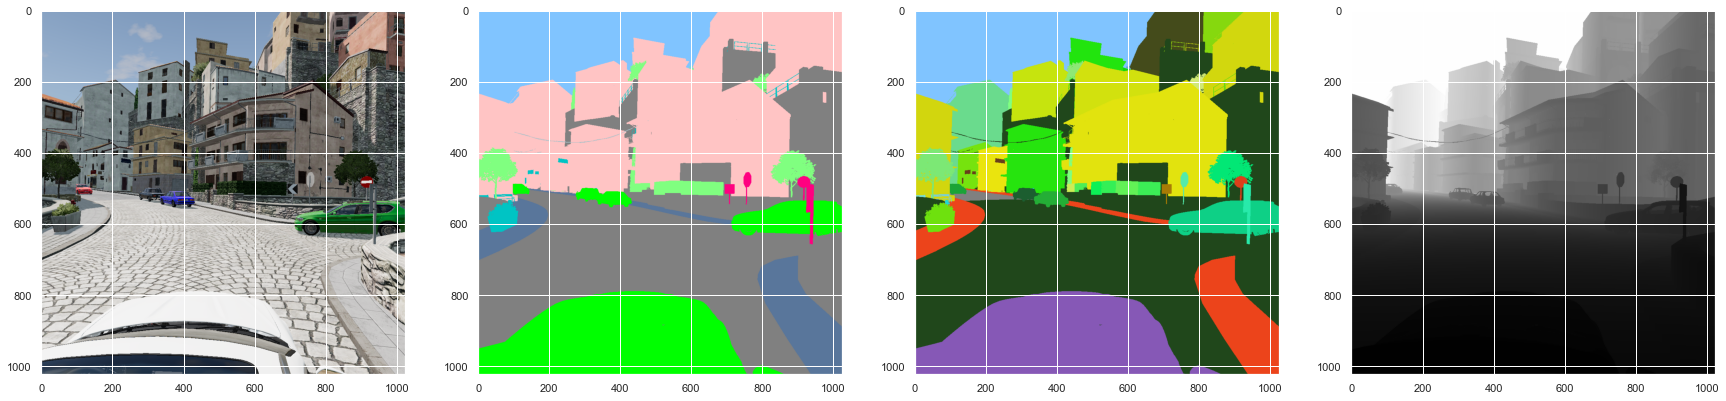

In [6]:
images = cam1.get_full_poll_request()

fig, ax = plt.subplots(1, 4, figsize=(30, 30))
ax[0].imshow(np.asarray(images['colour'].convert('RGB')))
ax[1].imshow(np.asarray(images['annotation'].convert('RGB')))
ax[2].imshow(np.asarray(images['instance'].convert('RGB')))
ax[3].imshow(np.asarray(images['depth'].convert('RGB')))
plt.show()

Using the camera utility functions `extract_bounding_boxes()` we get a collection of bounding boxes which contain all the separate instances in the data.

In [7]:
# Compute and display the bounding boxes for each vehicle instance.
print('Vehicle bounding boxes:')
bounding_boxes = Camera.extract_bounding_boxes(images['annotation'], images['instance'], class_data)
bounding_boxes = [b for b in bounding_boxes if b['class'] == 'CAR']
print(bounding_boxes)

Vehicle bounding boxes:
[{'bbox': [98, 488, 144, 518], 'class': 'CAR', 'color': [26, 164, 54, 255]}, {'bbox': [275, 500, 350, 538], 'class': 'CAR', 'color': [28, 94, 48, 255]}, {'bbox': [334, 510, 432, 554], 'class': 'CAR', 'color': [36, 174, 54, 255]}, {'bbox': [713, 536, 1023, 635], 'class': 'CAR', 'color': [14, 208, 134, 255]}, {'bbox': [0, 791, 858, 1023], 'class': 'CAR', 'color': [134, 88, 182, 255]}]


We can use this bounding box data to draw the said boxes onto the colour image which we got from the camera. This is done using `draw_bounding_boxes()`.  The resulting image is shown below, where we can see the boxes around each vehicle along with a text markup.

<Figure size 432x288 with 0 Axes>

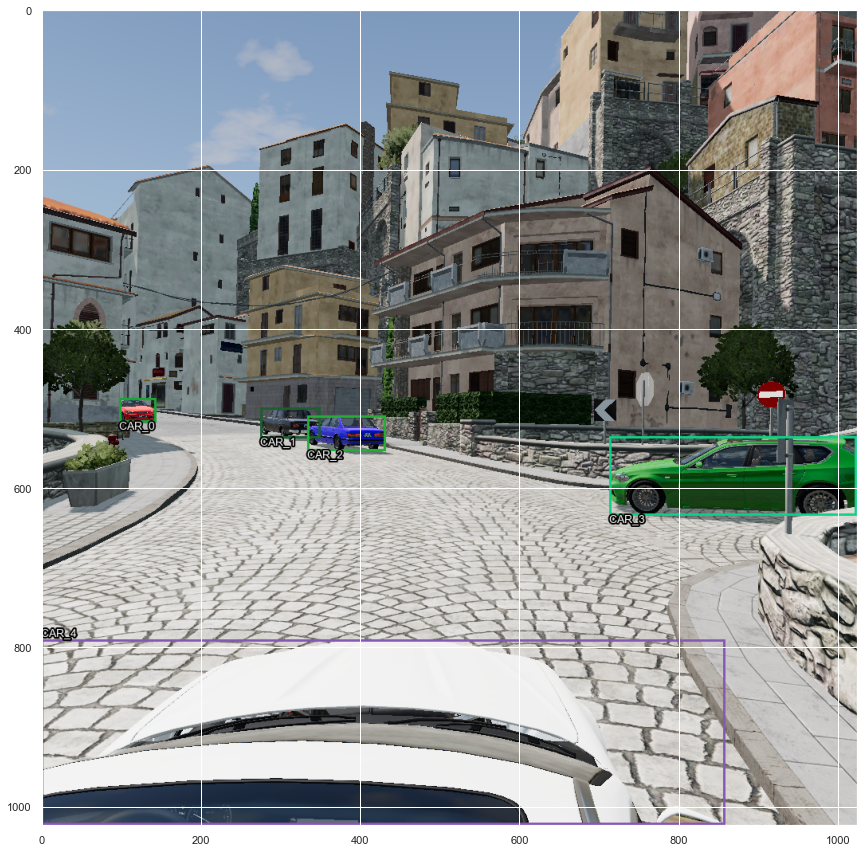

In [8]:
# Draw the bounding boxes on top of the colour image.
image_with_boxes = Camera.draw_bounding_boxes(bounding_boxes, images['colour'], width=3)
plt.clf()
plt.figure(figsize=(15, 15))
plt.imshow(np.asarray(image_with_boxes.convert('RGB')))
plt.show()

We also show how to export this data to file, in the common PASCAL-VOC format. The resulting XML is also shown below.

In [9]:
# Export the bounding boxes to PASCAL-VOC XML format.
print('XML file:')
xml = Camera.export_bounding_boxes_xml(bounding_boxes, filename='example.png', size=(1024, 1024, 3))
print(xml)

# Close the simulation.
bng.close()

XML file:
<?xml version="1.0" ?>
<annotation>
  <filename>example.png</filename>
  <size>
    <width>1024</width>
    <height>1024</height>
    <depth>3</depth>
  </size>
  <segmented>0</segmented>
  <object>
    <name>CAR_0</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>98</xmin>
      <ymin>488</ymin>
      <xmax>144</xmax>
      <ymax>518</ymax>
    </bndbox>
  </object>
  <object>
    <name>CAR_1</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>275</xmin>
      <ymin>500</ymin>
      <xmax>350</xmax>
      <ymax>538</ymax>
    </bndbox>
  </object>
  <object>
    <name>CAR_2</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>334</xmin>
      <ymin>510</ymin>
      <xmax>432</xmax>
      <ymax>554</ymax>
    </bndbox>
  </object>
  <object>
    <name>CAR_3</name>
    <pose>Uns